In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

#L1 norma
def norm(M):
    return np.sum(M)/M.shape[0]

def spectral_clustering(Cohord, tre ,first_index,last_index, cluster_borders):
    # Your spectral clustering implementation here
    M = Cohord[first_index:last_index, first_index:last_index]
    U , S, Vt= np.linalg.svd(M)
    drugi_svojstveni_vektor = U[:,1]
    perm = zip(drugi_svojstveni_vektor, range(first_index,last_index+1))
    sorted_perm = sorted(perm)
    sorted_indices = [index for value, index in sorted_perm]
    number_of_negative_values = sum(1 for value in drugi_svojstveni_vektor if value < 0)

    full_permutation = np.hstack([list(range(0,first_index)), sorted_indices, list(range(last_index+1,len(Cohord)))]).astype(int)
    new_Cohord = Cohord[full_permutation, :][:, full_permutation]
    norm1 = norm(new_Cohord[first_index:first_index+number_of_negative_values, first_index:first_index+number_of_negative_values])
    norm2 = norm(new_Cohord[first_index+number_of_negative_values:last_index+1, first_index+number_of_negative_values:last_index+1])
    if min(norm1, norm2) > tre:
        cluster_borders.append(first_index+number_of_negative_values)
        N1 = spectral_clustering(new_Cohord, tre, first_index, first_index+number_of_negative_values-1, cluster_borders)
        N2 = spectral_clustering(new_Cohord, tre, first_index+number_of_negative_values, last_index, cluster_borders)
        return new_Cohord, N1 + N2
    else:
        return Cohord, 1
    


import matplotlib.pyplot as plt


def show_heatmap_borders(matrix, title="Matrix Heatmap", cmap='viridis', cluster_borders=None):
    """
    Display a heatmap of the given matrix with optional cluster borders
    
    Parameters:
    - matrix: 2D numpy array or list
    - title: Title for the heatmap
    - cmap: Colormap (options: 'viridis', 'plasma', 'hot', 'cool', 'RdYlBu', etc.)
    - cluster_borders: List of indices where cluster borders should be drawn
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap=cmap, aspect='auto')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    
    # Draw cluster borders if provided
    if cluster_borders is not None and len(cluster_borders) > 0:
        for border in cluster_borders:
            # Draw vertical line (separating columns)
            plt.axvline(x=border - 0.5, color='red', linewidth=2, linestyle='--')
            # Draw horizontal line (separating rows)
            plt.axhline(y=border - 0.5, color='red', linewidth=2, linestyle='--')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# show_heatmap_borders(Cohord, title="Cohord Matrix Heatmap")
# show_heatmap_borders(Cohord, title="Cohord Matrix", cmap='hot', cluster_borders=[10, 25, 50])


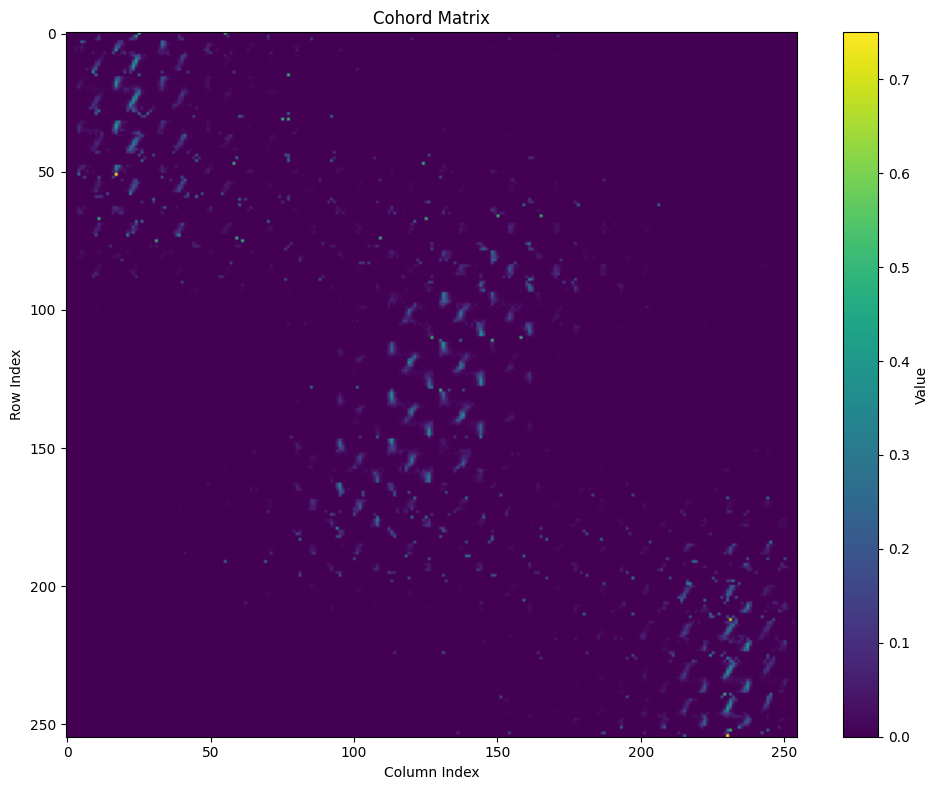

[47, 67, 108, 211]
Number of clusters found: 5


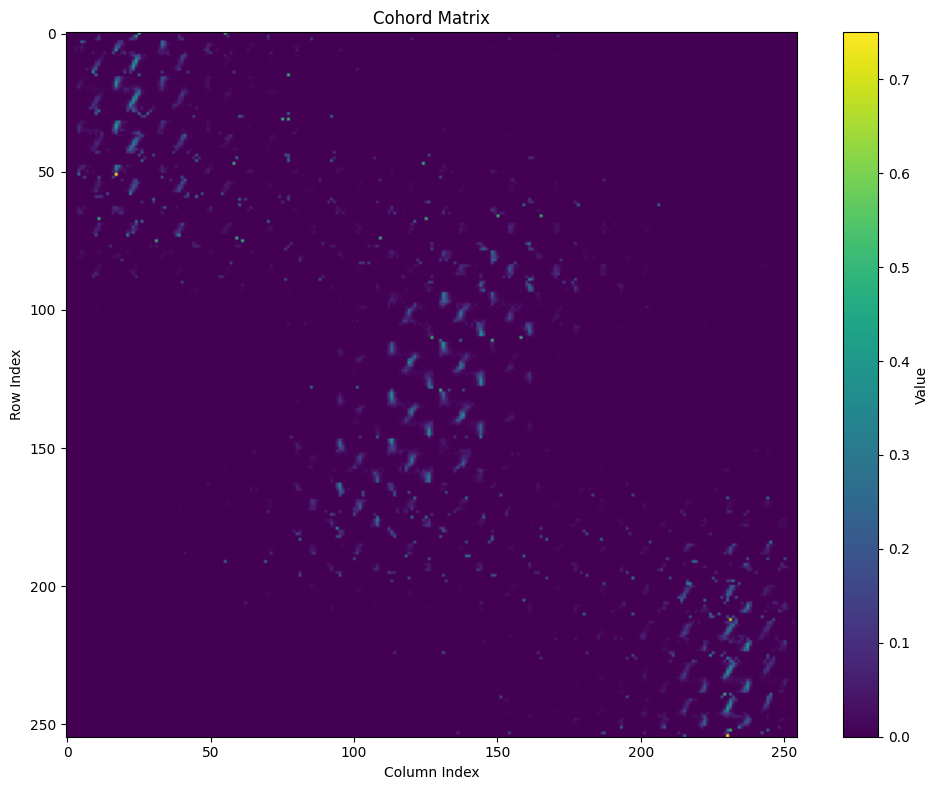

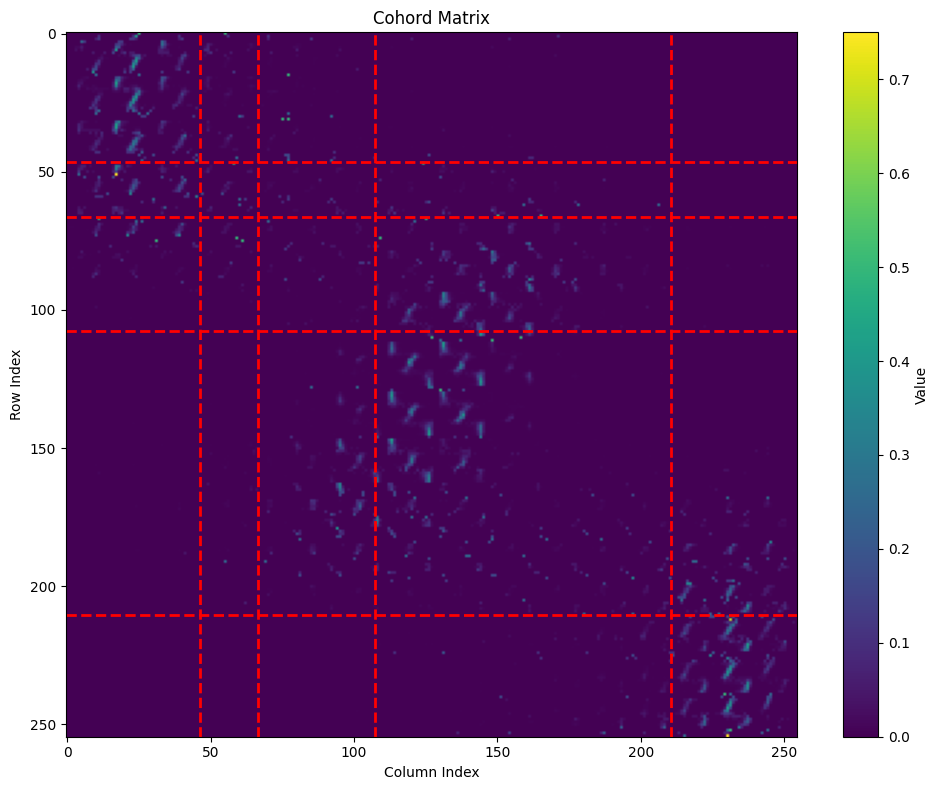

In [ ]:
# Load the .mat file
mat_data = scipy.io.loadmat('Ph300.mat')

tre = 0.8
# See what variables are in the file
#print("Variables in .mat file:", mat_data.keys())

# Access a specific matrix (replace 'matrix_name' with actual variable name)
Cohord = mat_data['Ph300']
Cohord = Cohord.toarray()
show_heatmap_borders(Cohord,title="Cohord Matrix", cluster_borders=None)

#print(Cohord)

cluster_borders = []
Cohord, N = spectral_clustering(Cohord, tre, 0, len(Cohord)-1, cluster_borders)
print(sorted(cluster_borders))
print("Number of clusters found:", N)
show_heatmap_borders(Cohord,title="Cohord Matrix", cluster_borders=None)
show_heatmap_borders(Cohord,title="Cohord Matrix", cluster_borders=cluster_borders)

